### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Master_Copy/CompletelyCleanCorpus_8_Topics"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 8, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]11:19:24 Generating bigrams
[INFO]11:19:24 Generating word bigrams
[INFO]11:19:28 Generated word bigrams
[INFO]11:19:30 Beginning lemmatization
[INFO]11:19:54 Ending lemmatization
[INFO]11:20:24 Issued perplexity: -8.26604415766586
[INFO]11:20:24 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.018*"number" + 0.017*"sample" + 0.016*"datum" + 0.013*"site" + 0.012*"estimate" + 0.011*"taxa" + 0.011*"method" + 0.010*"group" + 0.010*"taxonomic" + 0.009*"survey"'),
 (1,
  '0.059*"model" + 0.036*"people" + 0.019*"fishery" + 0.017*"migration" + 0.014*"predict" + 0.013*"climate_change" + 0.010*"scenario" + 0.010*"description" + 0.010*"arise" + 0.010*"inadequate"'),
 (2,
  '0.037*"stream" + 0.036*"urban" + 0.027*"undisturbed" + 0.018*"riparian" + 0.015*"trait" + 0.015*"britain" + 0.014*"frog" + 0.013*"acid" + 0.011*"specialist" + 0.010*"mark"'),
 (3,
  '0.044*"forest" + 0.022*"habitat" + 0.014*"site" + 0.013*"diversity" + 0.013*"tree" + 0.013*"community" + 0.009*"richness" + 0.009*"vegetation" + 0.007*"type" + 0.007*"abundance"'),
 (4,
  '0.026*"conservation" + 0.018*"biodiversity" + 0.008*"protect" + 0.007*"management" + 0.007*"resource" + 0.005*"local" + 0.005*"development" + 0.005*"reserve" + 0.005*"ecological" + 0.005*"research"'),
 (5,
  '0.039*"soil" + 0.039*"seed" + 0.

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 8, id2word = id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(num_topics = -1, formatted=False))

[(0,
  [('change', 0.02811771813238975),
   ('increase', 0.023267454906360577),
   ('impact', 0.015034089928368),
   ('decline', 0.014136532320704238),
   ('effect', 0.012462242167946837),
   ('time', 0.012030724087339259),
   ('rate', 0.010183826702338828),
   ('year', 0.009873133684301372),
   ('ecosystem', 0.009735047898506948),
   ('loss', 0.009372572710796582)]),
 (1,
  [('region', 0.021979386564013412),
   ('endemic', 0.015965656099767613),
   ('record', 0.013801422717354668),
   ('area', 0.013624026538468361),
   ('island', 0.013606286920579731),
   ('soil', 0.013286973798584378),
   ('taxa', 0.013269234180695748),
   ('represent', 0.009543914424083305),
   ('water', 0.009242340919976584),
   ('diversity', 0.009189122066310692)]),
 (2,
  [('richness', 0.033746395448523106),
   ('diversity', 0.024409632920271217),
   ('model', 0.021915672979502768),
   ('datum', 0.02049723326319071),
   ('distribution', 0.02038812251578209),
   ('pattern', 0.018704699555763385),
   ('scale', 0.01

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.44147291044555215


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

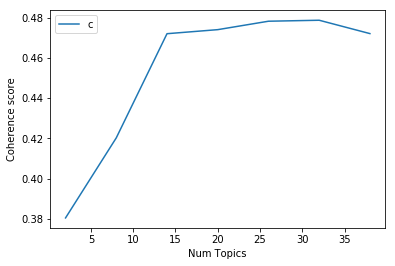

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(num_topics = -1, formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.028*"change" + 0.023*"increase" + 0.015*"impact" + 0.014*"decline" + '
  '0.012*"effect" + 0.012*"time" + 0.010*"rate" + 0.010*"year" + '
  '0.010*"ecosystem" + 0.009*"loss" + 0.008*"suggest" + 0.008*"range" + '
  '0.008*"condition" + 0.008*"climate_change" + 0.007*"period" + '
  '0.007*"future" + 0.007*"response" + 0.007*"result" + 0.007*"trend" + '
  '0.006*"climate" + 0.006*"wetland" + 0.006*"factor" + 0.006*"trait" + '
  '0.006*"potential" + 0.006*"dynamic" + 0.006*"decrease" + 0.006*"reduce" + '
  '0.005*"climatic" + 0.005*"current" + 0.005*"show" + 0.005*"long_term" + '
  '0.005*"dispersal" + 0.005*"ecological" + 0.005*"temperature" + '
  '0.005*"large" + 0.005*"lead" + 0.004*"growth" + 0.004*"control" + '
  '0.004*"season" + 0.004*"measure"'),
 (1,
  '0.022*"region" + 0.016*"endemic" + 0.014*"record" + 0.014*"area" + '
  '0.014*"island" + 0.013*"soil" + 0.013*"taxa" + 0.010*"represent" + '
  '0.009*"water" + 0.009*"diversity" + 0.009*"number" + 0.009*"total" + '
  '0.0

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2726,"change, increase, impact, decline, effect, tim...",[Abstract: 'Maintenance of soil health is cent...
1,1,2.0,0.4594,"richness, diversity, model, datum, distributio...",[Abstract: 'Plant invasion is highly responsiv...
2,2,0.0,0.4638,"change, increase, impact, decline, effect, tim...","[Abstract: 'Globally, treeline in mountain lan..."
3,3,0.0,0.4093,"change, increase, impact, decline, effect, tim...",[Abstract: 'Forests play a crucial role by reg...
4,4,0.0,0.2882,"change, increase, impact, decline, effect, tim...",[Abstract: 'The analysis of species distributi...
5,5,0.0,0.3458,"change, increase, impact, decline, effect, tim...",[Abstract: 'The Himalayan ecosystem is one of ...
6,6,0.0,0.4810,"change, increase, impact, decline, effect, tim...","[Abstract: 'In an era of climate change, predi..."
7,7,1.0,0.2414,"region, endemic, record, area, island, soil, t...",[Abstract: 'The relationship and its key predi...
8,8,0.0,0.5440,"change, increase, impact, decline, effect, tim...",[Abstract: 'Climate change effects on Himalaya...
9,9,0.0,0.3528,"change, increase, impact, decline, effect, tim...",[Abstract: 'With the threats of climate change...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"change, increase, impact, decline, effect, tim...",707.0,0.1494
1,2.0,"richness, diversity, model, datum, distributio...",536.0,0.1132
2,0.0,"change, increase, impact, decline, effect, tim...",555.0,0.1173
3,0.0,"change, increase, impact, decline, effect, tim...",528.0,0.1116
4,0.0,"change, increase, impact, decline, effect, tim...",612.0,0.1293
5,0.0,"change, increase, impact, decline, effect, tim...",638.0,0.1348
6,0.0,"change, increase, impact, decline, effect, tim...",698.0,0.1475
7,1.0,"region, endemic, record, area, island, soil, t...",459.0,0.0970
8,0.0,"change, increase, impact, decline, effect, tim...",NaN,NaN
9,0.0,"change, increase, impact, decline, effect, tim...",NaN,NaN


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      32.283230        1       1 -0.176169  0.015216
3      31.323418        1       2 -0.217898  0.029689
6      12.662625        1       3 -0.168922 -0.097555
0       9.642241        1       4 -0.131263 -0.173989
7       8.954147        1       5 -0.035383  0.307158
1       2.033579        1       6  0.227890 -0.039443
5       2.014140        1       7  0.253420 -0.021691
2       1.086622        1       8  0.248325 -0.019386, topic_info=      Category         Freq            Term        Total  loglift  logprob
4086   Default  6912.000000          forest  6912.000000  30.0000  30.0000
13958  Default  2648.000000      population  2648.000000  29.0000  29.0000
23132  Default  3062.000000           plant  3062.000000  28.0000  28.0000
12294  Default  1002.000000           model  1002.000000  27.0000  27.0000
16380  Default  4612.000000    conservation  4612.000000  26.0000  26.0000
21883  Default   993.000000            soil   993.000000  25.0000  25.0000
12323  Default  4079.000000       diversity  4079.000000  24.0000  24.0000
20772  Default  2804.000000            site  2804.000000  23.0000  23.0000
71     Default  2714.000000        richness  2714.000000  22.0000  22.0000
3569   Default  3331.000000    biodiversity  3331.000000  21.0000  21.0000
9944   Default  1537.000000    distribution  1537.000000  20.0000  20.0000
621    Default  2004.000000            tree  2004.000000  19.0000  19.0000
18161  Default  1164.000000         endemic  1164.000000  18.0000  18.0000
11875  Default  4342.000000         habitat  4342.000000  17.0000  17.0000
9618   Default  1378.000000          sample  1378.000000  16.0000  16.0000
12112  Default  2401.000000          number  2401.000000  15.0000  15.0000
9650   Default  1225.000000           datum  1225.000000  14.0000  14.0000
13542  Default   498.000000            seed   498.000000  13.0000  13.0000
8160   Default   484.000000          people   484.000000  12.0000  12.0000
4157   Default   828.000000         genetic   828.000000  11.0000  11.0000
8944   Default  2600.000000       community  2600.000000  10.0000  10.0000
6445   Default   911.000000          island   911.000000   9.0000   9.0000
5014   Default  1264.000000         pattern  1264.000000   8.0000   8.0000
19064  Default  1357.000000          change  1357.000000   7.0000   7.0000
11942  Default   931.000000            taxa   931.000000   6.0000   6.0000
8702   Default   751.000000         decline   751.000000   5.0000   5.0000
15474  Default   750.000000          method   750.000000   4.0000   4.0000
16540  Default  1440.000000          region  1440.000000   3.0000   3.0000
52     Default   744.000000        estimate   744.000000   2.0000   2.0000
254    Default  1324.000000           total  1324.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
16169   Topic8    82.043106           trait    83.157326   4.5086  -4.1981
14161   Topic8    81.380959         britain    82.499435   4.5084  -4.2062
10930   Topic8    75.935059            frog    77.049294   4.5075  -4.2755
16531   Topic8    71.607666            acid    72.726204   4.5066  -4.3342
6600    Topic8    56.838032            mark    57.953407   4.5027  -4.5652
1349    Topic8    51.248993            city    52.362541   4.5006  -4.6687
17866   Topic8    50.374863      netherland    51.490753   4.5002  -4.6859
20151   Topic8    41.582233          garden    42.696014   4.4957  -4.8777
3738    Topic8    41.670303          weakly    42.786549   4.4957  -4.8756
18516   Topic8    40.240974       occupancy    41.354774   4.4948  -4.9105
2190    Topic8    33.873524       seriously    34.989265   4.4897  -5.0827
10587   Topic8    33.559696  specialization    34.675674   4.4894  -5.0920
4765    Topic8    31.174057          matter    32.294113   4.4868  -5.1658
18661   Topic8    30.497194            ide